In [1]:
import pandas as pd 
import numpy as np 
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
# import zigzag
import plotly.express as px
import plotly.graph_objects as go

# Get BTC Data 15 min

In [2]:
df = pd.read_csv("BTC_Close.csv", index_col=0)
df.index = pd.to_datetime(df.index, unit='ms')
# data = df.resample('15T').last()

# ZigZag 函数

In [3]:
"""
reference:
https://github.com/jbn/ZigZag.git
"""
import numpy as np

PEAK = 1
VALLEY = -1


def identify_initial_pivot(X, up_thresh, down_thresh):
    x_0 = X[0]
    x_t = x_0

    max_x = x_0
    min_x = x_0

    max_t = 0
    min_t = 0

    up_thresh += 1
    down_thresh += 1

    for t in range(1, len(X)):
        x_t = X[t]

        if x_t / min_x >= up_thresh:
            return VALLEY if min_t == 0 else PEAK

        if x_t / max_x <= down_thresh:
            return PEAK if max_t == 0 else VALLEY

        if x_t > max_x:
            max_x = x_t
            max_t = t

        if x_t < min_x:
            min_x = x_t
            min_t = t

    t_n = len(X)-1
    return VALLEY if x_0 < X[t_n] else PEAK


def peak_valley_pivots(X, up_thresh, down_thresh):
    """
    Find the peaks and valleys of a series.

    :param X: the series to analyze
    :param up_thresh: minimum relative change necessary to define a peak
    :param down_thesh: minimum relative change necessary to define a valley
    :return: an array with 0 indicating no pivot and -1 and 1 indicating
        valley and peak


    The First and Last Elements
    ---------------------------
    The first and last elements are guaranteed to be annotated as peak or
    valley even if the segments formed do not have the necessary relative
    changes. This is a tradeoff between technical correctness and the
    propensity to make mistakes in data analysis. The possible mistake is
    ignoring data outside the fully realized segments, which may bias
    analysis.
    """
    if down_thresh > 0:
        raise ValueError('The down_thresh must be negative.')

    initial_pivot = identify_initial_pivot(X, up_thresh, down_thresh)
    t_n = len(X)
    pivots = np.zeros(t_n, dtype=np.int_)
    trend = -initial_pivot
    last_pivot_t = 0
    last_pivot_x = X[0]

    pivots[0] = initial_pivot

    # Adding one to the relative change thresholds saves operations. Instead
    # of computing relative change at each point as x_j / x_i - 1, it is
    # computed as x_j / x_1. Then, this value is compared to the threshold + 1.
    # This saves (t_n - 1) subtractions.
    up_thresh += 1
    down_thresh += 1

    for t in range(1, t_n):
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh:
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh:
                pivots[last_pivot_t] = trend
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t

    if last_pivot_t == t_n-1:
        pivots[last_pivot_t] = trend # 新趋势
    elif pivots[t_n-1] == 0:
        pivots[t_n-1] = -trend # 老趋势

    return pivots


def max_drawdown(X):
    """
    Compute the maximum drawdown of some sequence.

    :return: 0 if the sequence is strictly increasing.
        otherwise the abs value of the maximum drawdown
        of sequence X
    """
    mdd = 0
    peak = X[0]

    for x in X:
        if x > peak:
            peak = x

        dd = (peak - x) / peak

        if dd > mdd:
            mdd = dd

    return mdd if mdd != 0.0 else 0.0


def pivots_to_modes(pivots):
    """
    Translate pivots into trend modes.

    :param pivots: the result of calling ``peak_valley_pivots``
    :return: numpy array of trend modes. That is, between (VALLEY, PEAK] it
    is 1 and between (PEAK, VALLEY] it is -1.
    """

    modes = np.zeros(len(pivots), dtype=np.int_)
    mode = -pivots[0]

    modes[0] = pivots[0]

    for t in range(1, len(pivots)):
        x = pivots[t]
        if x != 0:
            modes[t] = mode
            mode = -x
        else:
            modes[t] = mode

    return modes


def compute_segment_returns(X, pivots):
    """
    :return: numpy array of the pivot-to-pivot returns for each segment."""
    pivot_points = np.array(X[pivots != 0])
    return pivot_points[1:] / pivot_points[:-1] - 1.0

# 做空

In [4]:
# TODO: 加上均线
def backtest(X, rise, down, take_profit=0, output=True):
    # pivots = peak_valley_pivots(X, rise, -rise)
    allowance = 10000
    cash = 0
    shares = 0
    low = None
    high = None
    n = len(X)
    cash_array = np.zeros(n)
    shares_array = np.zeros(n)
    actions = np.zeros(n)
    up_thresh, down_thresh = rise, down
    last_buy = 1000000
    last_sell = 0
    for i in range(n):
        if i == 0:
            initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = len(X)
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            continue
        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
                
        # if last_pivot_t == t_n-1:
        #     pivots[last_pivot_t] = trend # 新趋势
        # elif pivots[t_n-1] == 0:
        #     pivots[t_n-1] = -trend # 老趋势
            
        p = X[i] # 当前价格
        
        # if pivots[i] == -1:
        #     low = p
            
        # if pivots[i] == 1:
        #     high = p
            
        if low is None or high is None: # 确保已经有了low high
            continue

        if p < low and shares >= 0: # and p < high * (1-rise) # TODO: 增加频率，避免一下子跌太多，错过做空时机
            # 做空
            shares = -allowance / p
            cash += allowance
            if output: print("做空", p, X.index[i])
            actions[i] = -1
            last_sell = p
            
        if (p > high) and shares < 0: # and p > low * (1 + rise)
        # if (p > (0.5 * low + 0.5 * high)) and shares < 0: # 特殊止损条件
            # 平仓止损
            cash += shares * p
            if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = -2
            last_buy = p
        
        if (p < take_profit * last_sell) and shares < 0:
            # 止盈
            cash += shares * p
            if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = -3
            last_buy = p
            
        if i == len(pivots) - 1: # 最后时刻清仓
            cash += shares * p
            shares = 0
        
        cash_array[i] = cash
        shares_array[i] = shares
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "price": X, "pivots": pivots, "actions": actions})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["pnl"].diff().fillna(0) / allowance
    freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
    if len(rets) == 0:
        stats = {}
    else:
        time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
        total_return = df_pnl["pnl"][-1] / allowance
        yearly_return = total_return / time_length
        yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
        maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
        sharpe = yearly_return / yearly_vol
        stats = dict(rise=rise, down=down, freq=freq, take_profit=take_profit, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, pivots, actions, stats

## 每周做空

参数传入方式有点疑惑
如果传入X，那么需要一周的开始结束时间，如果传输的是开始结束时间，那么之后运行的时候可能消耗的内存比较大，但还好反正会释放掉，而且不用改可能还是一样的
要么又传入x，又传入时间，这样比较麻烦
或者传入X，然后自己判断开始结束时间，可以从X的index的date入手写，倒是也可以

In [5]:
# TODO: 加上均线
def backtest_weekly(X, rise, down, take_profit=0, output=True):
    # pivots = peak_valley_pivots(X, rise, -rise)

    low = None
    high = None
    up_thresh, down_thresh = rise, down

    before = X.index[0].date()
    start = X.index[0].date() + datetime.timedelta(days=7)
    end = X.index[-1].date()
    
    # 找到trend, low high
    m = len(X.loc[before: start])
    for i in range(m):
        if i == 0:
            initial_pivot = identify_initial_pivot(X[:m], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = m
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            continue
        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
    
    if low is None or high is None:
        print("low or high is None")
        return 0, 0, 0, {}



   
    allowance = 10000
    cash = 0
    shares = 0
    last_buy = 1000000
    last_sell = 1000000
    X = X.loc[start: end]
    n = len(X)
    cash_array = np.zeros(n)
    shares_array = np.zeros(n)
    actions = np.zeros(n)
    for i in range(n):        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t    
                  
        p = X[i] # 当前价格

        if p < low and shares >= 0: # and p < high * (1-rise) # TODO: 增加频率，避免一下子跌太多，错过做空时机
            # 做空
            shares = -allowance / p
            cash += allowance
            if output: print("做空", p, X.index[i])
            actions[i] = -1
            last_sell = p
            
        if (p > high) and shares < 0: # and p > low * (1 + rise)
        # if (p > (0.5 * low + 0.5 * high)) and shares < 0: # 特殊止损条件
            # 平仓止损
            cash += shares * p
            if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = -2
            last_buy = p
        
        # if (p < take_profit * last_sell) and shares < 0:
        #     # 止盈
        #     cash += shares * p
        #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
        #     shares = 0
        #     actions[i] = -3
        #     last_buy = p
            
        if i == len(pivots) - 1: # 最后时刻清仓
            cash += shares * p
            shares = 0
        
        cash_array[i] = cash
        shares_array[i] = shares
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "price": X, "pivots": pivots, "actions": actions})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["pnl"].diff().fillna(0) / allowance
    freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
    if len(rets) == 0:
        stats = {}
    else:
        time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
        total_return = df_pnl["pnl"][-1] / allowance
        yearly_return = total_return / time_length
        yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
        maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
        sharpe = yearly_return / yearly_vol
        stats = dict(rise=rise, down=down, freq=freq, take_profit=take_profit, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, pivots, actions, stats

In [6]:
# # TODO: 加上均线
# def backtest_weekly(X, rise, down, take_profit=0, output=True):

#     low = None
#     high = None
#     up_thresh, down_thresh = rise, down
    
#     # 回看一星期
#     before = X.index[0].date()
#     start = X.index[0].date() + datetime.timedelta(days=7)
#     end = X.index[-1].date()
    
#     # 寻找之前的high, low, trend
#     pivots = peak_valley_pivots(X.loc[before: start], rise, down)
#     try:
#         high_t = np.where(pivots[1:-1] == 1)[0][-1] + 1
#         low_t = np.where(pivots[1:-1] == -1)[0][-1] + 1
#     except:
#         print("Low or High is None")
#         return 0,0,0, {}
#     trend = -1 if high_t > low_t else 1
#     high = X[high_t]
#     low = X[low_t]
    
#     # 之字转向回测
#     allowance = 10000
#     cash = 0
#     shares = 0
#     last_buy = 1000000
#     last_sell = 1000000
#     # X 调整为后半部分 
#     X = X.loc[start: end]
#     n = len(X)
#     cash_array = np.zeros(n)
#     shares_array = np.zeros(n)
#     actions = np.zeros(n)
#     for i in range(n):
#         # i = 0 时 初始化
#         if i == 0:
#             last_pivot_t = 0
#             last_pivot_x = X[0]
#             pivots = np.zeros(n, dtype=np.int_)
#             continue
                
#         t = i
#         x = X[t]
#         r = x / last_pivot_x

#         if trend == -1:
#             if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
#                 pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
#                 low = last_pivot_x
#                 trend = PEAK
#                 last_pivot_x = x
#                 last_pivot_t = t
#             elif x < last_pivot_x:
#                 last_pivot_x = x
#                 last_pivot_t = t
#         else:
#             if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
#                 pivots[last_pivot_t] = trend
#                 high = last_pivot_x
#                 trend = VALLEY
#                 last_pivot_x = x
#                 last_pivot_t = t
#             elif x > last_pivot_x:
#                 last_pivot_x = x
#                 last_pivot_t = t    
                  
#         # 做多做空策略
#         p = X[i] # 当前价格
#         if p < low and shares >= 0: # and p < high * (1-rise) # TODO: 增加频率，避免一下子跌太多，错过做空时机
#             # 做空
#             shares = -allowance / p
#             cash += allowance
#             if output: print("做空", p, X.index[i])
#             actions[i] = -1
#             last_sell = p
            
#         if (p > high) and shares < 0: # and p > low * (1 + rise)
#         # if (p > (0.5 * low + 0.5 * high)) and shares < 0: # 特殊止损条件
#             # 平仓止损
#             cash += shares * p
#             if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
#             shares = 0
#             actions[i] = -2
#             last_buy = p
        
#         # if (p < take_profit * last_sell) and shares < 0:
#         #     # 止盈
#         #     cash += shares * p
#         #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
#         #     shares = 0
#         #     actions[i] = -3
#         #     last_buy = p
            
#         if i == len(pivots) - 1: # 最后时刻清仓
#             cash += shares * p
#             shares = 0
        
#         cash_array[i] = cash
#         shares_array[i] = shares
    
    
#     ## 计算收益
#     df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "price": X, "pivots": pivots, "actions": actions})
#     df_pnl.index = X.index
#     df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    
#     # 计算收益率等参数
#     df_pnl["ret"] = df_pnl["pnl"].diff().fillna(0) / allowance
#     freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
#     rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
#     if len(rets) == 0:
#         stats = {}
#     else:
#         time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
#         total_return = df_pnl["pnl"][-1] / allowance
#         yearly_return = total_return / time_length
#         yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
#         maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
#         sharpe = yearly_return / yearly_vol
#         stats = dict(rise=rise, down=down, freq=freq, take_profit=take_profit, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
#     # stats = [rise, total_return, yearly_vol, maxdrawdown]
#     return df_pnl, pivots, actions, stats

## 参数1

做空 3964.45 2019-01-08 01:15:00
止损 3950.49 2019-01-08 05:45:00 盈亏 35.21295513879522
做空 4000.48 2019-01-08 15:45:00
止损 3980.15 2019-01-08 17:00:00 盈亏 50.81890173179272
做空 3962.0 2019-01-08 17:45:00
止损 3976.62 2019-01-08 19:30:00 盈亏 -36.90055527511322
做空 3965.4 2019-01-08 20:45:00
止损 3973.04 2019-01-09 01:15:00 盈亏 -19.266656579411574
做空 3976.43 2019-01-09 08:00:00
止损 3991.79 2019-01-09 09:15:00 盈亏 -38.627613210845084
做空 3978.0 2019-01-09 09:45:00
止损 3997.0 2019-01-09 11:15:00 盈亏 -47.76269482151838
做空 3976.01 2019-01-09 12:30:00
止损 3970.93 2019-01-09 16:00:00 盈亏 12.776627825383912
做空 3964.32 2019-01-09 23:15:00
止损 3975.43 2019-01-10 00:00:00 盈亏 -28.024982846995044
做空 3975.96 2019-01-10 02:15:00
止损 3985.37 2019-01-10 03:15:00 盈亏 -23.66724011307997
做空 3961.71 2019-01-10 06:15:00
止损 3732.02 2019-01-10 15:00:00 盈亏 579.7748951841495
做空 3717.03 2019-01-10 15:30:00
止损 3578.49 2019-01-10 19:15:00 盈亏 372.71692722415537
做空 3585.62 2019-01-10 20:45:00
止损 3595.01 2019-01-10 23:30:00 盈亏 -26.18793960319

,rise,down,freq,take_profit,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,start_date,end_date
0,0.001,-0.001,15.0,0.9,0.066897,0.542255,0.041435,13.260172,0.009304,2019-01-08,2019-01-15


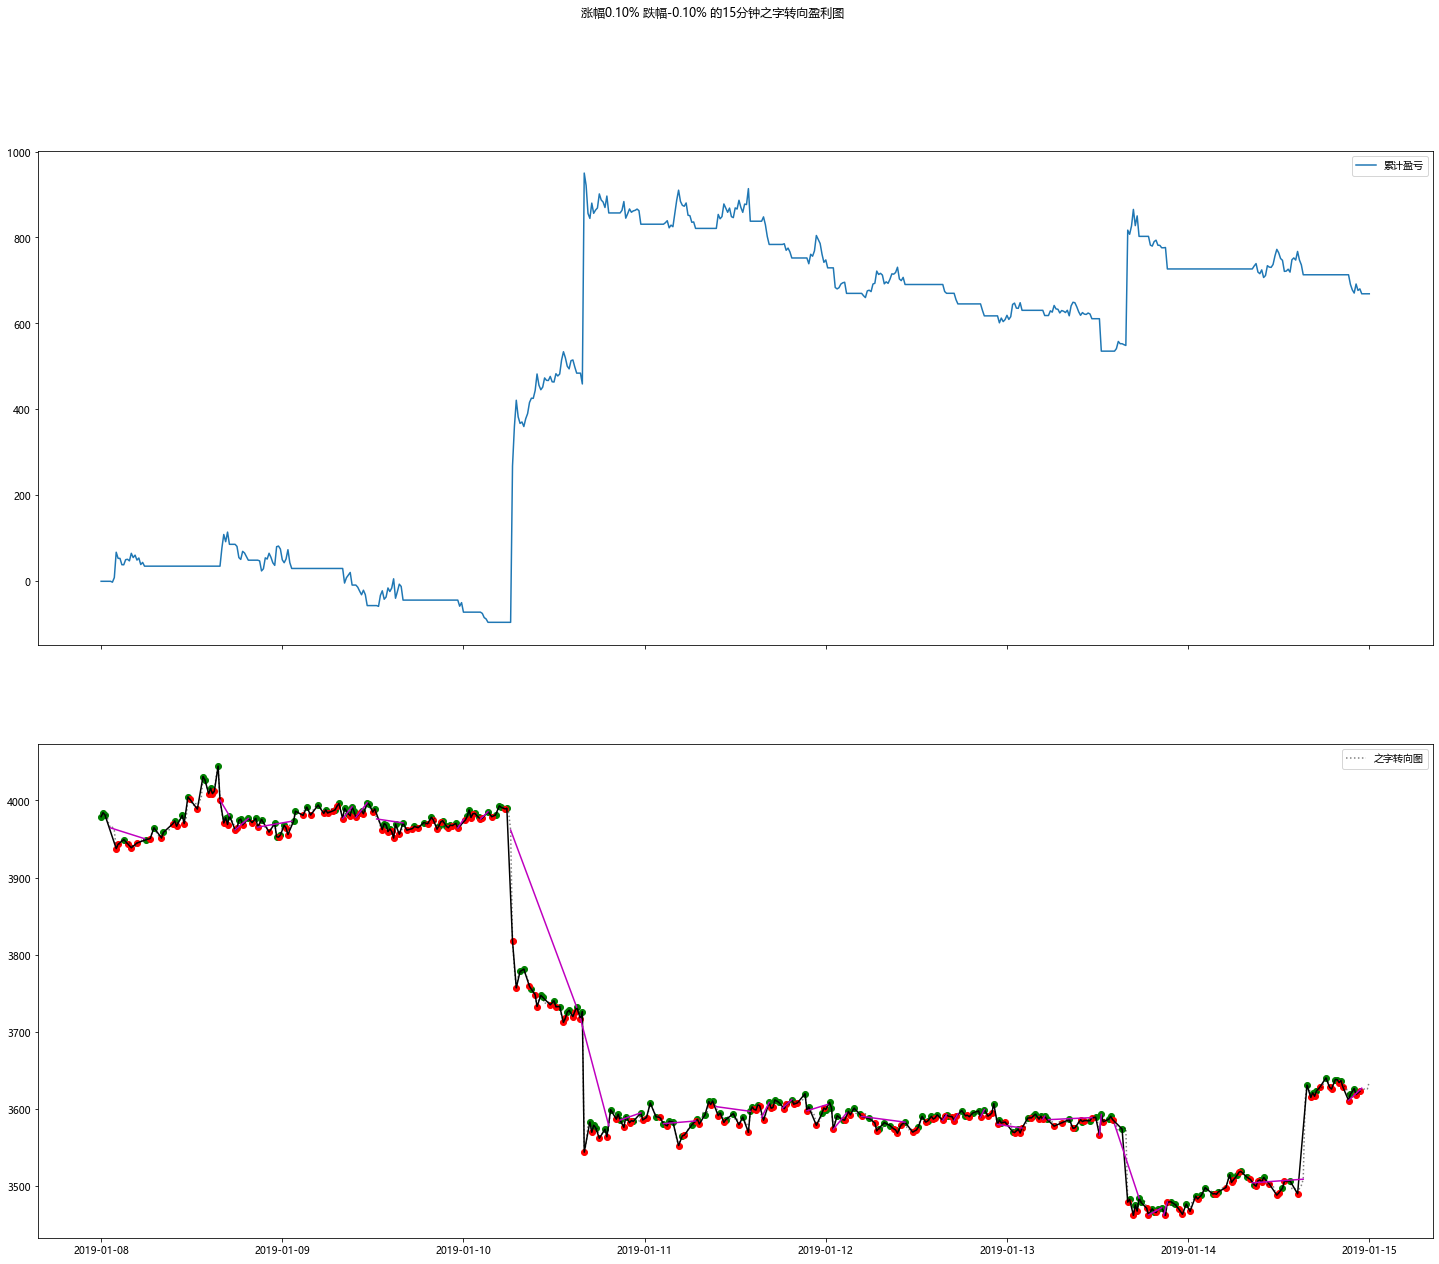

In [7]:
freq = 15
rise = 0.001
down = -0.001
take_profit = 0.9
start_date = datetime.datetime(2019, 1, 1)
end_date = datetime.datetime(2019, 1, 15)
data = df.resample(f'{freq}T').last()
X = data["Close"].loc[start_date:end_date]
df_pnl, pivots, actions, stats = backtest_weekly(X, rise, down, take_profit, True)
X = X.loc[start_date + datetime.timedelta(days=7):end_date]
display(pd.DataFrame([stats]))

## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])

In [26]:
start = "2022-01-01"
end = "2022-07-01"
freq = 15
rise = 0.03
down = -0.03
take_profit = 0.9
data = df.resample(f'{freq}T').last()
stats_list = []
for start_date in pd.date_range(start=start, end=end, freq="W-FRI"):
    end_date = start_date + datetime.timedelta(days=14)

    X = data["Close"].loc[start_date:end_date]
    df_pnl, pivots, actions, stats = backtest_weekly(X, rise, down, take_profit, False)
    # X = X.loc[start_date + datetime.timedelta(days=7):end_date]
    # display(pd.DataFrame([stats]))
    stats_list.append(stats)

<AxesSubplot:>

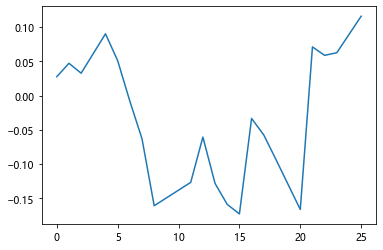

In [27]:
df_stats = pd.DataFrame(stats_list).dropna()
df_stats["total_return"].cumsum().plot(label="累计盈亏")

## 参数2

做空 3434.15 2019-01-28 00:00:00
止盈 3411.04 2019-01-29 00:00:00 盈亏 67.29467262641447
做空 3405.37 2019-02-06 00:00:00
止盈 3398.4 2019-02-07 00:00:00 盈亏 20.46767311628355
做空 3715.3 2019-03-04 00:00:00
止损 4144.56 2019-04-01 00:00:00 盈亏 -1155.3844911581837
做空 8115.82 2019-06-03 00:00:00
止盈 7687.03 2019-06-04 00:00:00 盈亏 528.3384796607133
做空 7628.13 2019-06-09 00:00:00
止损 7982.75 2019-06-10 00:00:00 盈亏 -464.8845785271096
做空 10854.1 2019-06-30 00:00:00
止盈 10624.93 2019-07-01 00:00:00 盈亏 211.13680544678937
做空 10174.18 2019-07-14 00:00:00
止盈 9439.59 2019-07-16 00:00:00 盈亏 722.0139608302579
做空 9476.52 2019-07-27 00:00:00
止损 10080.53 2019-07-31 00:00:00 盈亏 -637.3753234309643
做空 10892.71 2019-08-13 00:00:00
止盈 10050.37 2019-08-14 00:00:00 盈亏 773.3061836769721
做空 9721.0 2019-08-28 00:00:00
止盈 9498.44 2019-08-29 00:00:00 盈亏 228.94763913177485
做空 9584.54 2019-08-30 00:00:00
止损 10615.28 2019-09-03 00:00:00 盈亏 -1075.4193732823896
做空 9986.39 2019-09-21 00:00:00
止盈 9702.25 2019-09-23 00:00:00 盈亏 284.5272415

,rise,down,freq,take_profit,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,start_date,end_date
0,0.01,-0.04,1440.0,1,1.496243,0.406858,0.206939,3.890744,0.945205,2019-01-01,2022-07-31


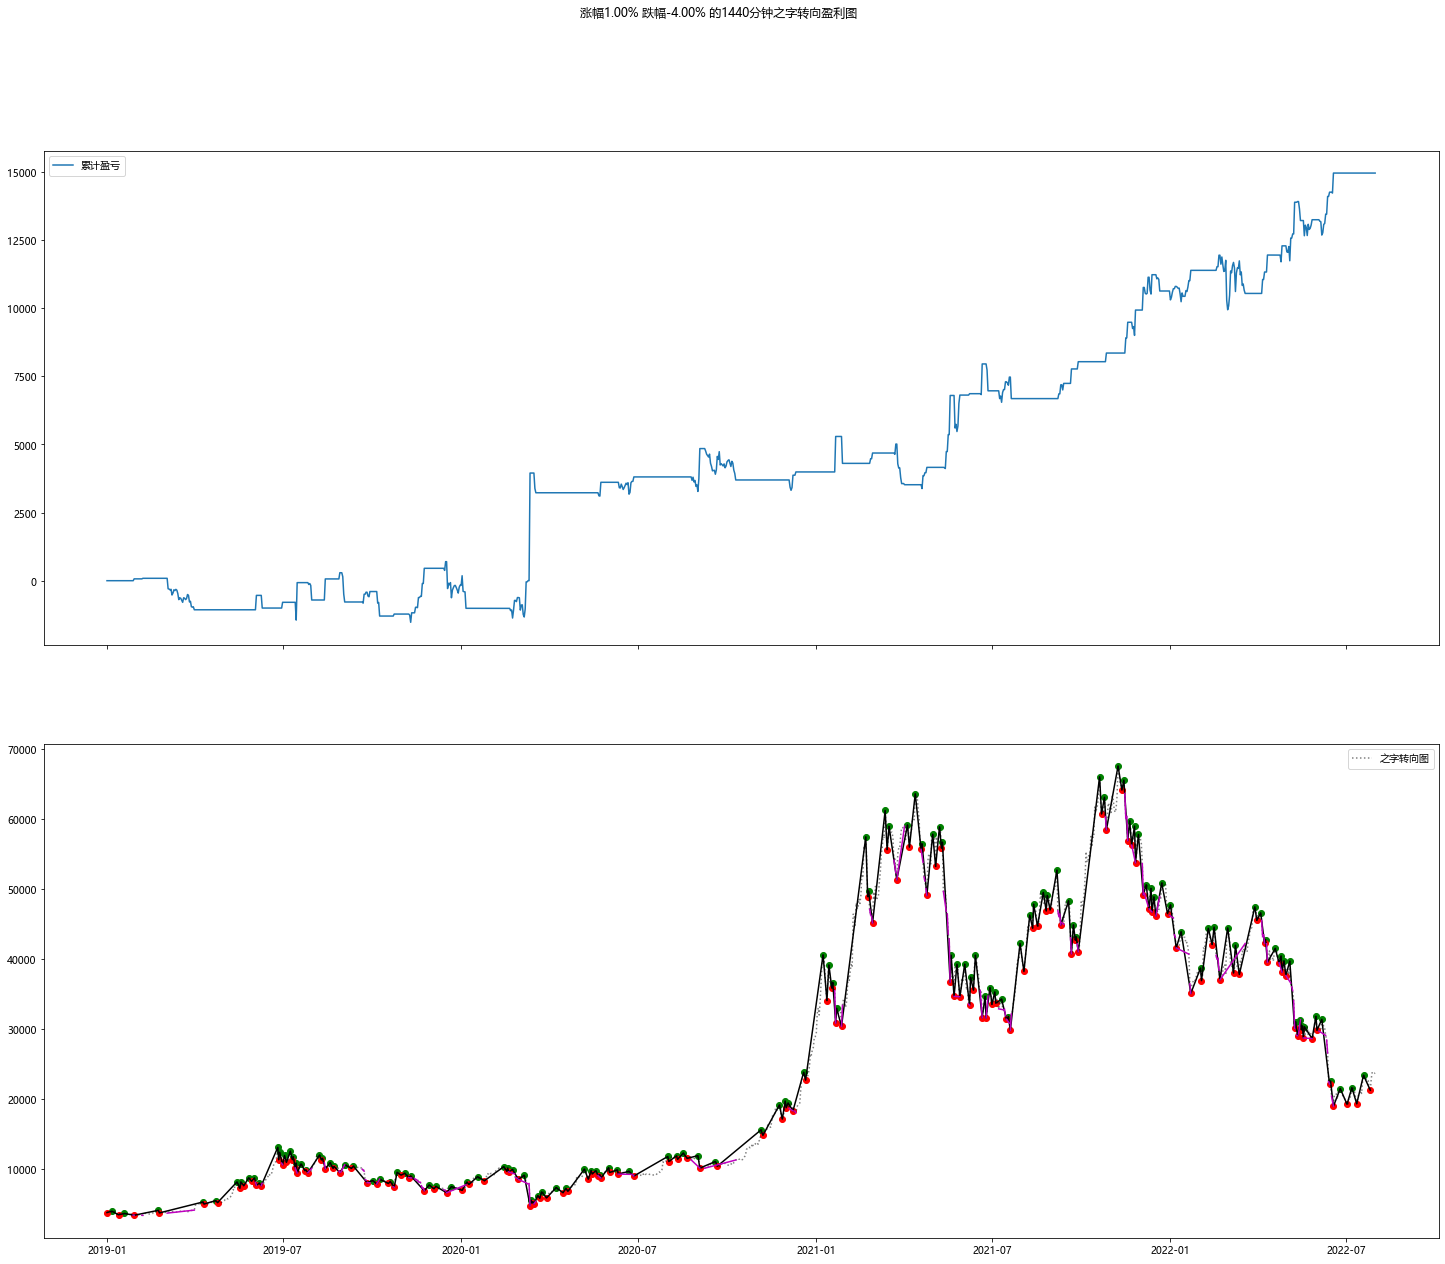

In [13]:
freq = 1440
rise = 0.01
down = -0.04
take_profit = 1
start_date = "2019"
data = df.resample(f'{freq}T').last()
X = data["Close"].loc[start_date:]
df_pnl, pivots, actions, stats = backtest(X, rise, down, take_profit, True)

display(pd.DataFrame([stats]))
## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])

In [16]:
def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)
safe_arange(0.6, 1, 0.05)

array([0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

# 做多

In [17]:
# TODO: 加上均线
def backtest_long(X, rise, down, take_profit=0, output=True):
    # pivots = peak_valley_pivots(X, rise, -rise)
    allowance = 10000
    cash = 0
    shares = 0
    low = None
    high = None
    n = len(X)
    cash_array = np.zeros(n)
    shares_array = np.zeros(n)
    actions = np.zeros(n)
    up_thresh, down_thresh = rise, down
    last_buy = 1000000
    last_sell = 1000000
    for i in range(n):
        if i == 0:
            initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = len(X)
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            continue
        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
                
        # if last_pivot_t == t_n-1:
        #     pivots[last_pivot_t] = trend # 新趋势
        # elif pivots[t_n-1] == 0:
        #     pivots[t_n-1] = -trend # 老趋势
            
        p = X[i] # 当前价格
        
        # if pivots[i] == -1:
        #     low = p
            
        # if pivots[i] == 1:
        #     high = p
            
        if low is None or high is None: # 确保已经有了low high
            continue

        # if p < low and shares >= 0: # and p < high * (1-rise) # TODO: 增加频率，避免一下子跌太多，错过做空时机
        if p > high and shares <= 0:
            # 做多
            shares = allowance / p
            cash -= allowance
            if output: print("做多", p, X.index[i])
            actions[i] = 1
            last_buy = p
            
        # if (p > high) and shares < 0: # and p > low * (1 + rise)
        if (p < low) and shares > 0:
        # if (p > (0.5 * low + 0.5 * high)) and shares < 0: # 特殊止损条件
            # 平仓止损
            cash += shares * p
            if output: print("止损", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = 2
            last_sell = p
        
        if (p > take_profit * last_buy) and shares > 0:
            # 止盈
            cash += shares * p
            if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
            shares = 0
            actions[i] = 3
            last_sell = p
            
        if i == len(pivots) - 1: # 最后时刻清仓
            cash += shares * p
            shares = 0
        
        cash_array[i] = cash
        shares_array[i] = shares
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "price": X, "pivots": pivots, "actions": actions})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["pnl"].diff().fillna(0) / allowance
    freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
    if len(rets) == 0:
        stats = {}
    else:
        time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
        total_return = df_pnl["pnl"][-1] / allowance
        yearly_return = total_return / time_length
        yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
        maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
        sharpe = yearly_return / yearly_vol
        stats = dict(rise=rise, down=down, freq=freq, take_profit=take_profit, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, pivots, actions, stats

## 参数1

做多 3680.06 2019-02-10 00:00:00
止盈 3898.6 2019-02-18 00:00:00 盈亏 20593.849013331303
做多 3907.79 2019-02-19 00:00:00
止盈 3969.74 2019-02-20 00:00:00 盈亏 20158.529501329394
做多 3937.31 2019-02-21 00:00:00
止盈 3962.0 2019-02-22 00:00:00 盈亏 20062.707787804364
做多 4117.76 2019-02-23 00:00:00
止损 3715.3 2019-03-04 00:00:00 盈亏 19022.623950885918
做多 4144.56 2019-04-01 00:00:00
止盈 4857.29 2019-04-02 00:00:00 盈亏 21719.675912521474
做多 4932.6 2019-04-03 00:00:00
止盈 5004.95 2019-04-05 00:00:00 盈亏 20146.677208774276
做多 5043.89 2019-04-06 00:00:00
止盈 5170.27 2019-04-07 00:00:00 盈亏 20250.56057923547
做多 5236.9 2019-04-08 00:00:00
止盈 5308.25 2019-04-10 00:00:00 盈亏 20136.244724932687
做多 5357.14 2019-04-22 00:00:00
止盈 5493.31 2019-04-23 00:00:00 盈亏 20254.184135564872
做多 5415.0 2019-04-24 00:00:00
止盈 5492.87 2019-05-02 00:00:00 盈亏 20143.804247460757
做多 5772.69 2019-05-03 00:00:00
止盈 5829.45 2019-05-04 00:00:00 盈亏 20098.325044303434
做多 5775.62 2019-05-05 00:00:00
止盈 5846.34 2019-05-07 00:00:00 盈亏 20122.445728770246

,rise,down,freq,take_profit,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,start_date,end_date
0,0.01,-0.04,1440.0,1,2.973299,0.436273,0.480014,5.270246,1.293151,2019-01-01,2022-07-31


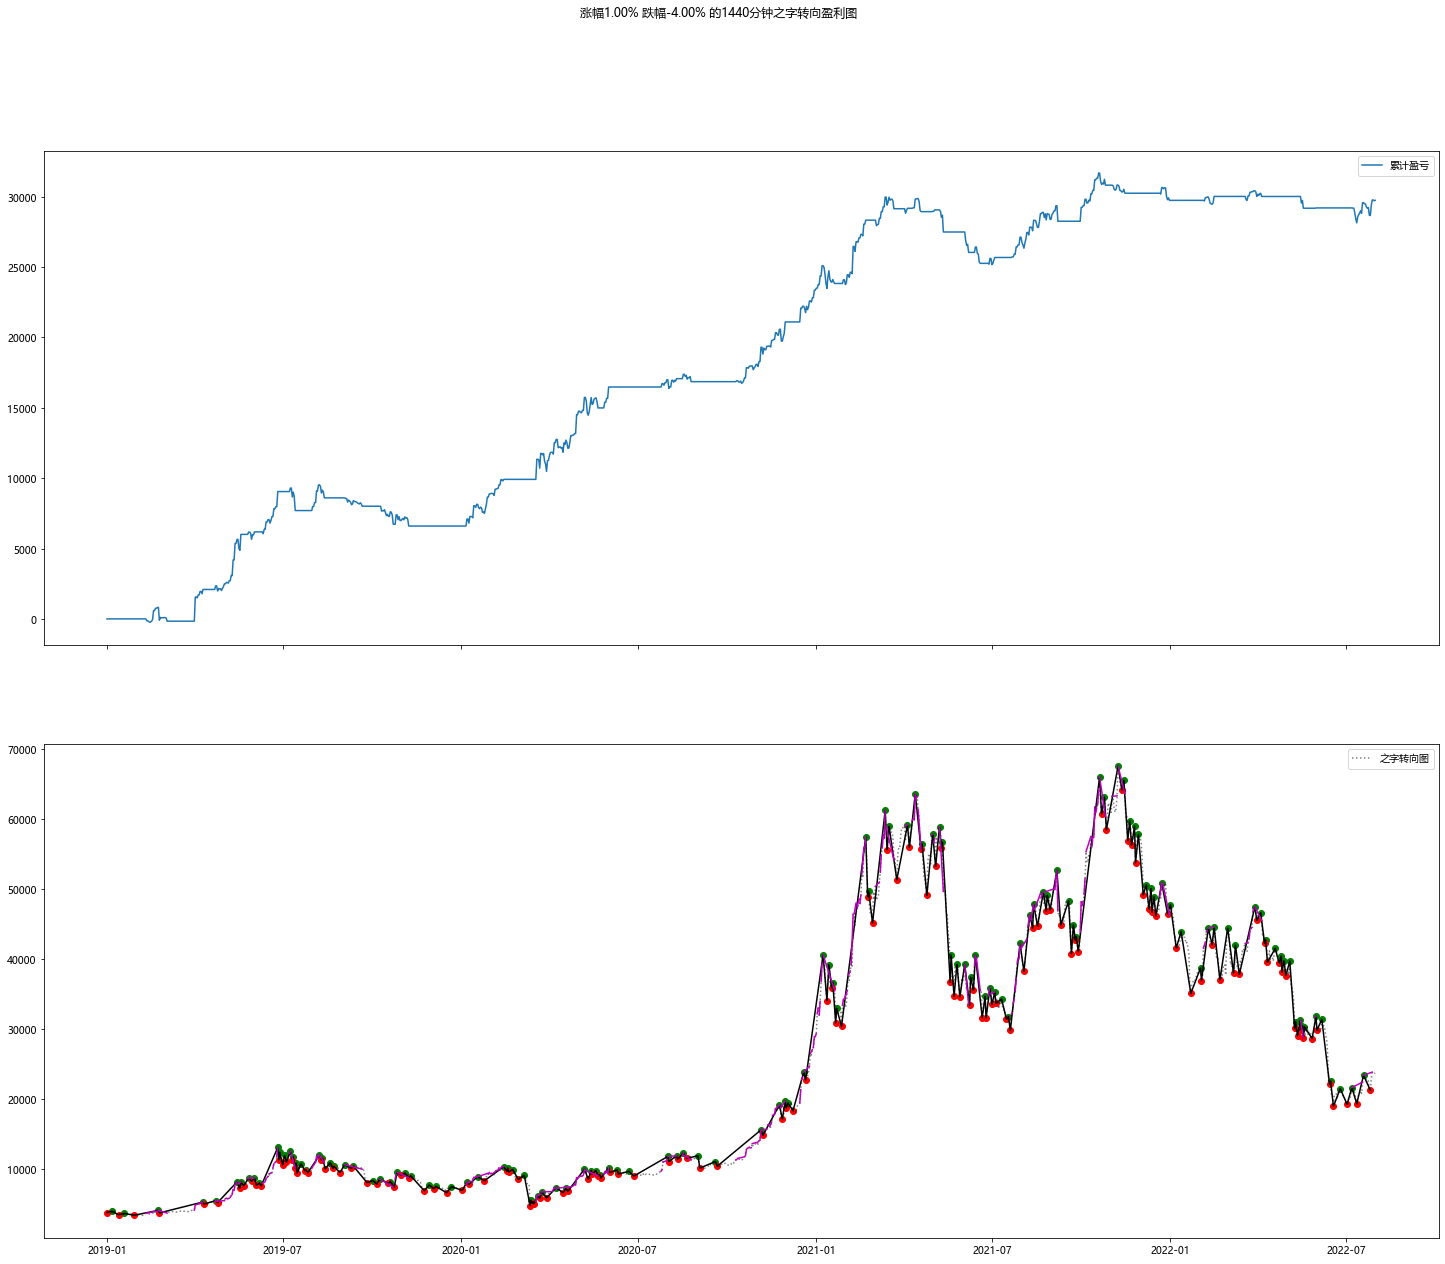

In [18]:
freq = 1440
rise = 0.01
down = -0.04
take_profit = 1
start_date = "2019"
data = df.resample(f'{freq}T').last()
X = data["Close"].loc[start_date:]
df_pnl, pivots, actions, stats = backtest(X, rise, down, take_profit, True)

display(pd.DataFrame([stats]))
## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])

## 参数2

做多 3745.37 2019-02-18 00:00:00
止盈 4144.68 2019-02-24 00:00:00 盈亏 21066.142997888062
做多 4722.27 2019-04-02 00:00:00
止盈 5236.9 2019-04-08 12:00:00 盈亏 21089.793679734532
做多 5153.36 2019-04-09 00:00:00
止盈 5750.99 2019-05-03 00:00:00 盈亏 21159.68998866759
做多 5772.69 2019-05-03 12:00:00
止盈 6373.33 2019-05-10 12:00:00 盈亏 21040.485458252566
做多 6754.55 2019-05-11 00:00:00
止盈 7790.71 2019-05-13 12:00:00 盈亏 21534.017810216814
做多 8059.98 2019-05-14 00:00:00
止损 8115.82 2019-06-03 12:00:00 盈亏 20069.280568934413
做多 8808.7 2019-06-15 12:00:00
止盈 9808.89 2019-06-21 00:00:00 盈亏 21135.456991383515
做多 10159.86 2019-06-21 12:00:00
止盈 11418.37 2019-06-25 00:00:00 盈亏 21238.708013693104
做多 11820.86 2019-06-25 12:00:00
止盈 13093.8 2019-06-26 12:00:00 盈亏 21076.85904409662
做多 12238.6 2019-07-08 12:00:00
止损 11303.01 2019-07-13 00:00:00 盈亏 19235.5416469204
做多 10080.53 2019-07-31 12:00:00
止盈 11777.64 2019-08-05 00:00:00 盈亏 21683.55235290208
做多 11828.8 2019-08-05 12:00:00
止损 11280.39 2019-08-13 00:00:00 盈亏 19536.37731

,rise,down,freq,take_profit,total_return,yearly_vol,maxdrawdown,sharpe,hold_time,start_date,end_date
0,0.02,-0.05,720.0,1.1,3.142701,0.478244,0.394626,3.738951,1.757534,2019-01-01,2022-07-31


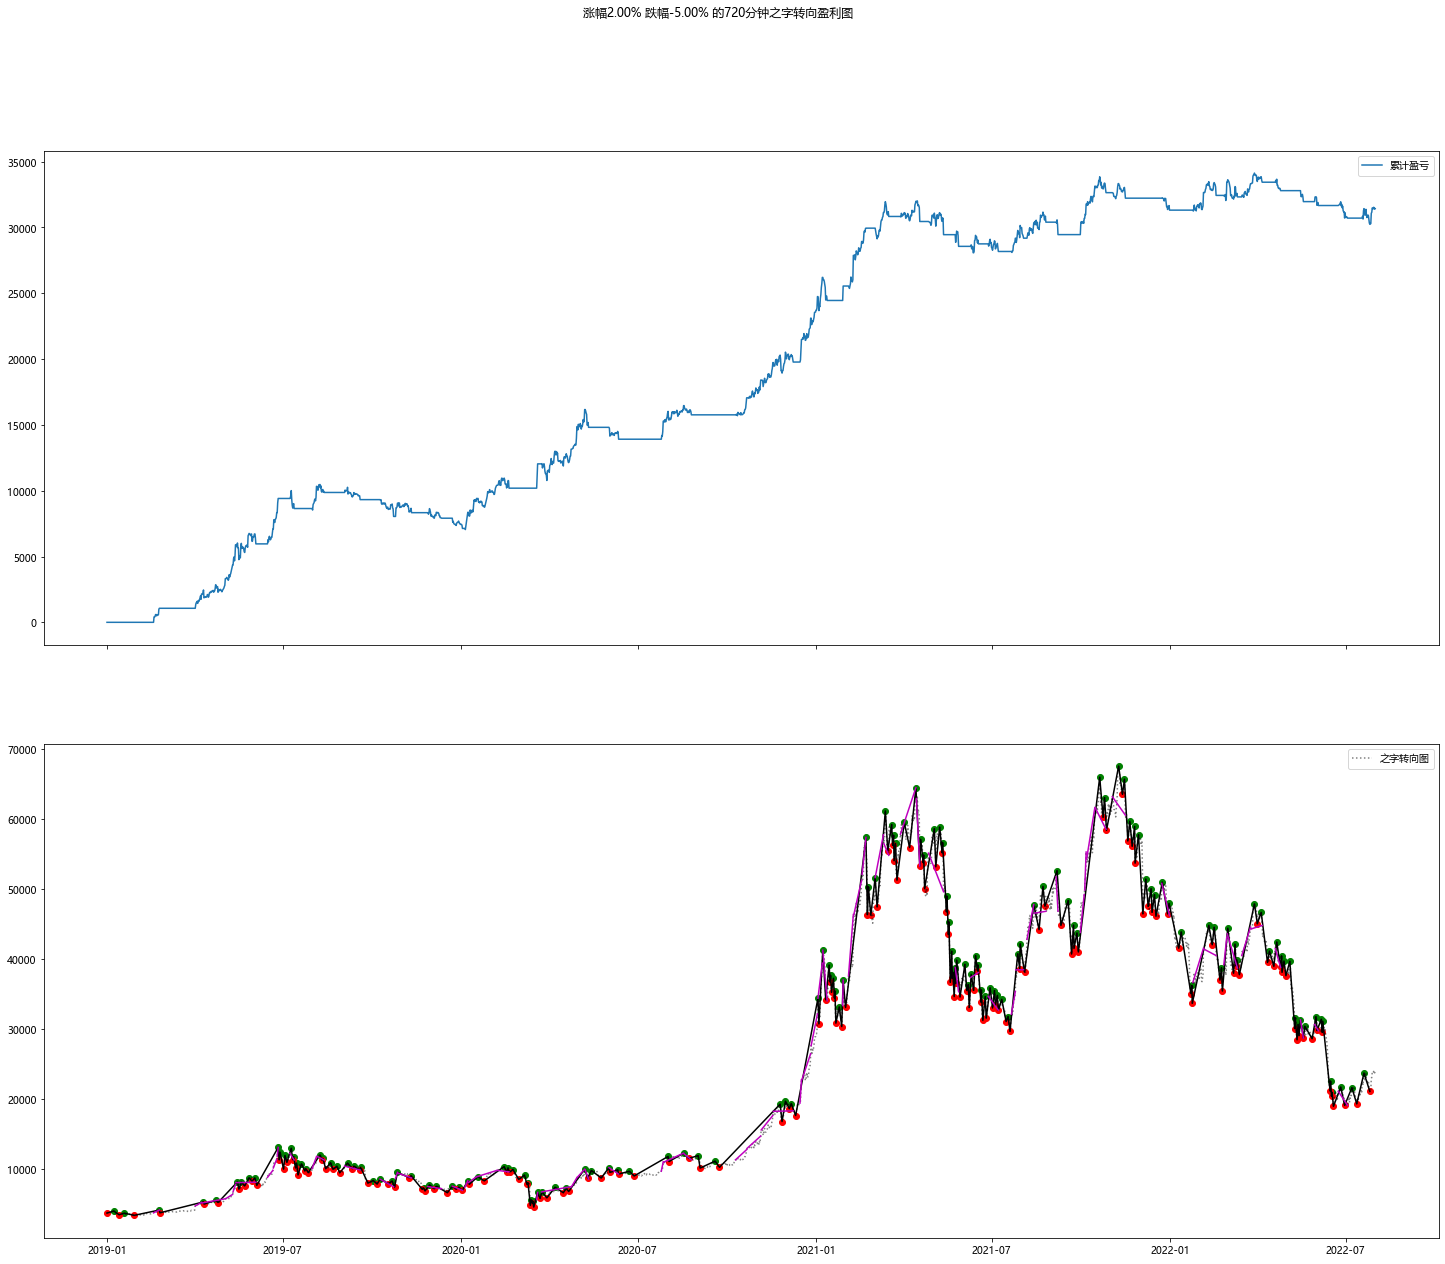

In [21]:
# freq = 7200
# rise = 0.05
# down = -0.01
# take_profit = 1

rise, down, freq, take_profit = 0.02, -0.05, 720, 1.1
start_date = "2019"
data = df.resample(f'{freq}T').last()
X = data["Close"].loc[start_date:]
df_pnl, pivots, actions, stats = backtest(X, rise, down, take_profit, True)

display(pd.DataFrame([stats]))
## 绘图
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(25, 20), sharex=True)
ax1.plot(df_pnl[["pnl"]])
ax1.legend(["累计盈亏"])
ax2.plot(X, 'k:', alpha=0.5)
ax2.plot(X[pivots != 0], 'k-')
ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
for i in range(len(X[actions != 0]) // 2):
    ax2.plot(X[actions != 0][i*2:i*2+2], 'm-')
# ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# plot_pivots(X, pivots, ax=ax2)
fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
ax2.legend(["之字转向图"])

# 结合做多做空

In [9]:
# TODO: 加上均线
# 可能需要两套体系来存放
# 买入卖出都设置为1BTC
def backtest_both(X, rise, down, take_profit_long=10, take_profit_short=0, output=True):
    # pivots = peak_valley_pivots(X, rise, -rise)
    allowance = 1
    cash = 0
    shares_long = 0
    shares_short = 0
    low = None
    high = None
    n = len(X)
    cash_array = np.zeros(n)
    shares_long_array = np.zeros(n)
    shares_short_array = np.zeros(n)
    actions_long = np.zeros(n)
    actions_short = np.zeros(n)
    cum_returns = np.zeros(n)
    up_thresh, down_thresh = rise, down
    last_buy = 1000000
    last_sell = 1000000
    last_price = 0
    for i in range(n):
        if i == 0:
            initial_pivot = identify_initial_pivot(X[:100], up_thresh, down_thresh) # 这个会数据泄漏
            t_n = len(X)
            pivots = np.zeros(t_n, dtype=np.int_)
            trend = -initial_pivot
            last_pivot_t = 0
            last_pivot_x = X[0]

            pivots[0] = initial_pivot
            up_thresh += 1
            down_thresh += 1
            last_price = X[i]
            continue
        
        t = i
        x = X[t]
        r = x / last_pivot_x

        if trend == -1:
            if r >= up_thresh: # 如果上升幅度超过阈值，则标记上个点为谷底
                pivots[last_pivot_t] = trend # 上一个被标记为谷底的点
                low = last_pivot_x
                trend = PEAK
                last_pivot_x = x
                last_pivot_t = t
            elif x < last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t
        else:
            if r <= down_thresh: # 如果下降幅度超过阈值，则标记上个点为顶点
                pivots[last_pivot_t] = trend
                high = last_pivot_x
                trend = VALLEY
                last_pivot_x = x
                last_pivot_t = t
            elif x > last_pivot_x:
                last_pivot_x = x
                last_pivot_t = t   
            
        p = X[i] # 当前价格
            
        if low is None or high is None: # 确保已经有了low high
            continue
        
        ## 计算收益率
        cur_return = 0 
        if shares_long > 0:        
            cur_return += (p - last_price) / last_buy
        if shares_short < 0:
            cur_return += (last_price - p) / last_sell
        cum_returns[i] = cur_return + cum_returns[i - 1]
        last_price = p
        
        if (p < low) and shares_long > 0: # 如果当前价格小于谷底，并且有持仓，则卖出止损
            # 平仓止损
            cash += shares_long * p
            if output: print("止损", p, X.index[i], "盈亏", p - last_buy)
            shares_long = 0
            actions_long[i] = 2
            last_sell = p
        
        # if (p > take_profit_long * last_buy) and shares > 0: # 如果当前价格大于买入价格的止盈，并且有持仓，则卖出止盈
        #     # 止盈
        #     cash += shares * p
        #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
        #     shares = 0
        #     actions[i] = 3
        #     last_sell = p
        
        if (p > high) and shares_short < 0: # 如果当前价格大于顶点，并且有做空持仓，则买入止损
            # 平仓止损
            cash += shares_short * p
            if output: print("止损", p, X.index[i], "盈亏", last_sell - p)
            shares_short = 0
            actions_short[i] = -2
            last_buy = p


            
        
        # if (p < take_profit_short * last_sell) and shares < 0: # 如果当前价格小于卖出价格的止盈，并且有做空，则买入止盈
        #     # 止盈
        #     cash += shares * p
        #     if output: print("止盈", p, X.index[i], "盈亏", allowance + shares * p)
        #     shares = 0
        #     actions[i] = -3
        #     last_buy = p
            
        if p > high and shares_long == 0: # 如果当前价格大于顶点，并且没有持仓，则做多
            # 做多
            shares_long = allowance
            cash -= shares_long * p
            if output: print("做多", p, X.index[i])
            actions_long[i] = 1
            last_buy = p
        
        if p < low and shares_short == 0: # 如果当前价格小于谷底，并且没有持仓，则做空
            # 做空
            shares_short = -allowance
            cash -= shares_short * p
            if output: print("做空", p, X.index[i])
            actions_short[i] = -1
            last_sell = p
            
            
        if i == len(pivots) - 1: # 最后时刻清仓
            cash += (shares_short + shares_long) * p
            shares_short = shares_long = 0
        
        cash_array[i] = cash
        shares_long_array[i] = shares_long
        shares_short_array[i] = shares_short
    
    shares_array = shares_long_array + shares_short_array
    if last_pivot_t == t_n-1:
        pivots[last_pivot_t] = trend # 新趋势
    elif pivots[t_n-1] == 0:
        pivots[t_n-1] = -trend # 老趋势
    
    ## 计算收益
    df_pnl = pd.DataFrame({"cash": cash_array, "shares": shares_array, "actions_long": actions_long, "actions_short": actions_short, "price": X, "pivots": pivots})
    df_pnl.index = X.index
    df_pnl["pnl"] = df_pnl["cash"] + df_pnl["shares"] * df_pnl["price"]
    df_pnl["cum_return"] = cum_returns
    
    # 计算收益率等参数
    df_pnl["ret"] = df_pnl["cum_return"].diff().fillna(0)
    freq = (df_pnl.index[1] - df_pnl.index[0]).total_seconds() // 60
    rets = df_pnl.loc[df_pnl["ret"] != 0, "ret"]
    if len(rets) == 0:
        stats = {}
    else:
        time_length = rets.shape[0] * ((df_pnl.index[1] - df_pnl.index[0]).total_seconds() / 3600 / 24 / 365)
        total_return = df_pnl["cum_return"][-1]
        yearly_return = total_return / time_length
        yearly_vol = df_pnl["ret"].std() * np.sqrt(60 / freq * 24 * 365)
        maxdrawdown = max(rets.cumsum().cummax() - rets.cumsum())
        sharpe = yearly_return / yearly_vol
        stats = dict(rise=rise, down=down, freq=freq, take_profit_long=take_profit_long, take_profit_short=take_profit_short, total_return=total_return, yearly_vol=yearly_vol, maxdrawdown=maxdrawdown, sharpe=sharpe, hold_time=time_length, start_date=X.index[0].date(), end_date=X.index[-1].date())
    # stats = [rise, total_return, yearly_vol, maxdrawdown]
    return df_pnl, stats

## 参数1

In [78]:
# rise, down, freq, take_profit_long, take_profit_short = 0.13, -0.06, 720, 2, 0.9
# start_date = "2019"
# data = df.resample(f'{freq}T').last().fillna(method="ffill")
# X = data["Close"].loc[start_date:]
# df_pnl, stats = backtest_both(X, rise, down, take_profit_long,take_profit_short, True)

# display(pd.DataFrame([stats]))
# ## 绘图
# pivots = df_pnl["pivots"]
# fig, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(25, 20), sharex=True)
# ax1.plot(df_pnl[["cum_return"]])
# ax1.legend(["累计盈亏比例"])
# ax2.plot(X, 'k:', alpha=0.5)
# ax2.plot(X[pivots != 0], 'k-')
# ax2.scatter(X[pivots == 1].index, X[pivots == 1], color='g')
# ax2.scatter(X[pivots == -1].index, X[pivots == -1], color='r')
# ax3.plot(df_pnl[["pnl"]])
# actions = df_pnl["actions_short"]
# for i in range(len(X[actions < 0]) // 2): # 做空
#     ax2.plot(X[actions < 0][i*2:i*2+2], 'm-')
# actions = df_pnl["actions_long"]
# for i in range(len(X[actions > 0]) // 2): # 做多
#     ax2.plot(X[actions > 0][i*2:i*2+2], 'y-')
# # ax2.scatter(X[actions == -1].index, X[actions == -1], color='b', s=100)
# # ax2.scatter(X[actions == -2].index, X[actions == -2], color='purple', s=100)
# # plot_pivots(X, pivots, ax=ax2)
# fig.suptitle(f"涨幅{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图")
# ax2.legend(["之字转向图"])
# ax3.legend(["累计盈亏值"])


start = "2020-01-01"
end = "2022-07-01"
freq = 240
rise = 0.02
down = -0.01
take_profit = 0.9
data = df.resample(f'{freq}T').last().fillna(method="ffill")
stats_list = []
week_freq = "W-FRI"
for start_date in pd.date_range(start=start, end=end, freq=week_freq):
    end_date = start_date + datetime.timedelta(days=7)

    X = data["Close"].loc[start_date:end_date]
    df_pnl, stats = backtest_both(X, rise, down, take_profit, output=False)
    # X = X.loc[start_date + datetime.timedelta(days=7):end_date]
    # display(pd.DataFrame([stats]))
    stats_list.append(stats)

df_stats = pd.DataFrame(stats_list)
df_stats.index = pd.date_range(start=start, end=end, freq=week_freq)
mean_stats = df_stats.select_dtypes(include=["float","int"]).mean()
mean_stats["total_return"] = df_stats["total_return"].sum()
mean_stats["strategy_pct"] = 1 - df_stats.isna().sum().max() / df_stats.shape[0]
mean_stats

rise                   0.020000
down                  -0.010000
freq                 240.000000
take_profit_long       0.900000
take_profit_short      0.000000
total_return           0.799583
yearly_vol             0.541923
maxdrawdown            0.069815
sharpe                 1.830147
hold_time              0.010951
strategy_pct           0.938931
dtype: float64

Text(0.5, 1.0, '每周上涨1.00% 跌幅-1.00% 的180分钟之字转向盈利图')

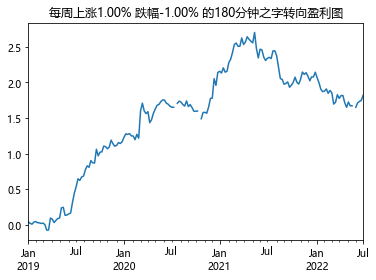

In [68]:
df_stats["total_return"].cumsum().plot()
plt.title("每周上涨{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图".format(rise=rise, down=down, freq=freq))

Text(0.5, 1.0, '每周上涨1.00% 跌幅-1.00% 的180分钟之字转向盈利图')

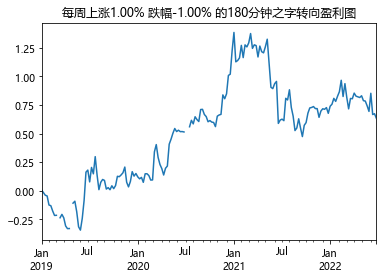

In [71]:
df_stats["total_return"].cumsum().plot()
plt.title("每周上涨{rise:.2%} 跌幅{down:.2%} 的{freq}分钟之字转向盈利图".format(rise=rise, down=down, freq=freq))